In [1]:
import numpy as np
import tensorflow as tf
from gpflow import set_trainable
from gpflow.ci_utils import ci_niter
from gpflow.kernels import RBF
from gpflow.likelihoods import Gaussian
from matplotlib import pyplot as plt
from markovflow.kernels import Matern32
from markovflow.models import SparseSpatioTemporalVariational
from markovflow.ssm_natgrad import SSMNaturalGradient

np.random.seed(10)

2022-01-12 12:59:45.177653: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-01-12 12:59:45.177691: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Declaring the model 

In [2]:
M_time = 7
M_space = 4

kernel_space = RBF(variance=1.0, lengthscales=0.2)
kernel_time = Matern32(variance=1.0, lengthscale=0.2)
likelihood = Gaussian(variance=0.1)

inducing_space = np.linspace(0.1, 0.9, M_space).reshape(-1, 1)
inducing_time = np.linspace(0, 1, M_time).reshape(-1, )

model = SparseSpatioTemporalVariational(
    inducing_time=tf.identity(inducing_time),
    inducing_space=tf.identity(inducing_space),
    kernel_space=kernel_space,
    kernel_time=kernel_time,
    likelihood=likelihood,
)

Instructions for updating:
Do not call `graph_parents`.


2022-01-12 12:59:47.004554: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-12 12:59:47.004781: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-01-12 12:59:47.004797: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-12 12:59:47.004823: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az90-583): /proc/driver/nvidia/version does not exist
2022-01-12 12:59:47.005137: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FM

In [3]:
# Creating data
num_data = 200
time_points = np.random.rand(num_data, 1)
space_points = np.random.rand(num_data, 1)
X = np.concatenate([space_points, time_points], -1)
f = lambda v: np.cos(5.0 * (v[..., 1:] + v[..., :1]))
F = f(X)
Y = F + np.random.randn(num_data, 1)
data = (X, Y)

Creating a plotting grid and plotting function

In [4]:
x_grid, t_grid = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
X_grid = np.concatenate([x_grid.reshape(-1, 1), t_grid.reshape(-1, 1)], axis=-1)


def plot_model(model):
    mu_f, var_f = model.space_time_predict_f(X_grid)
    fig, axarr = plt.subplots(2, 1)
    axarr[0].scatter(x=space_points, y=time_points, c=Y)
    axarr[1].scatter(x=X_grid[..., :1], y=X_grid[..., 1:], c=mu_f.numpy())

    for ax in axarr:
        ax.hlines(model.inducing_space, xmin=time_points.min(), xmax=time_points.max(), colors="r")
        ax.vlines(
            model.inducing_space, ymin=space_points.min(), ymax=space_points.max(), colors="k"
        )

    plt.savefig("spatio_temporal.pdf", dpi=300)
    plt.show()

Training

In [5]:
# Start at a small learning rate
adam_learning_rate = 0.0001
natgrad_learning_rate = 0.5

adam_opt = tf.optimizers.Adam(learning_rate=adam_learning_rate)
natgrad_opt = SSMNaturalGradient(gamma=natgrad_learning_rate, momentum=False)

set_trainable(model.ssm_q, False)
adam_var_list = model.trainable_variables  # trainable_variables
set_trainable(model.ssm_q, True)

2022-01-12 12:59:47.151240: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [6]:
# tf.function
def loss(input_data):
    return -model.elbo(input_data)


# tf.function
def opt_step(input_data):
    natgrad_opt.minimize(lambda: loss(input_data), model.ssm_q)
    adam_opt.minimize(lambda: loss(input_data), adam_var_list)

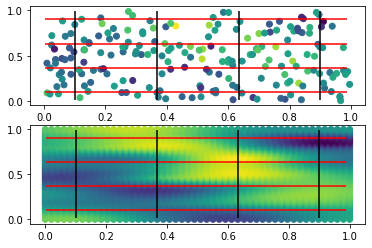

Iteration: 0 , Loss: 799.8748404900261


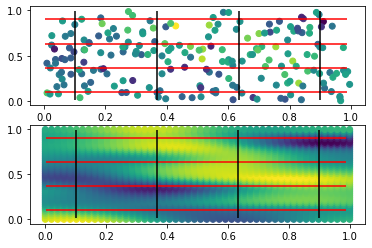

Iteration: 20 , Loss: 750.1320650431326


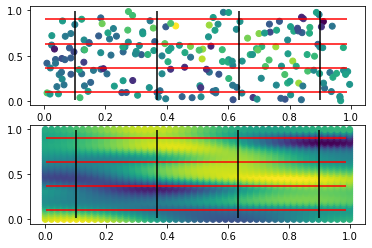

Iteration: 40 , Loss: 748.4102915678644


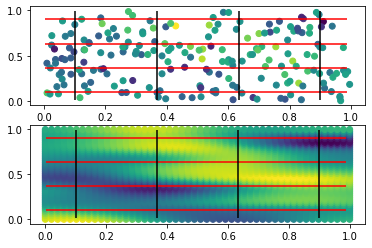

Iteration: 60 , Loss: 746.6998899644573


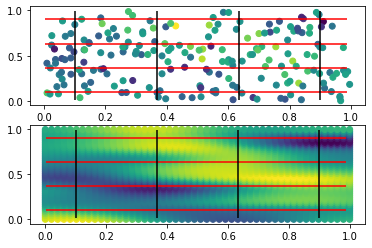

Iteration: 80 , Loss: 745.0015782026737


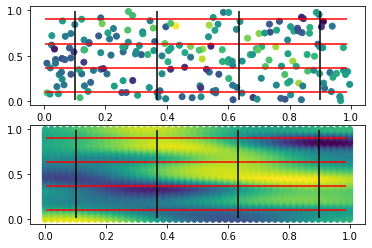

Iteration: 100 , Loss: 743.3154925672086


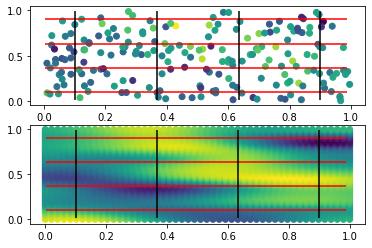

Iteration: 120 , Loss: 741.6415841128191


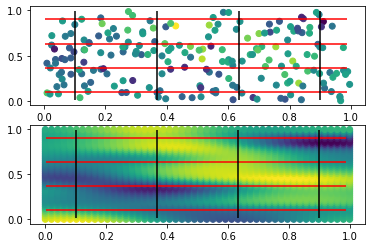

Iteration: 140 , Loss: 739.979739677305


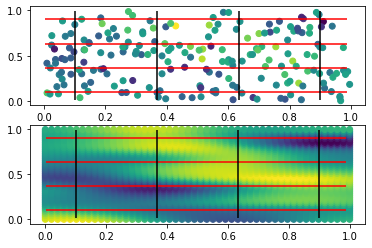

Iteration: 160 , Loss: 738.3298201315656


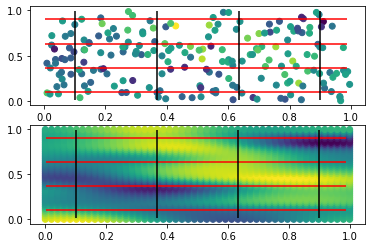

Iteration: 180 , Loss: 736.6916747225354


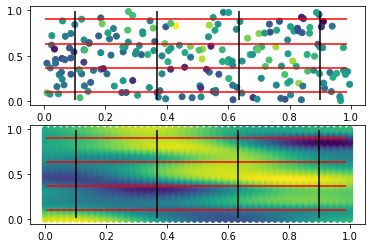

Iteration: 200 , Loss: 735.0651475029968


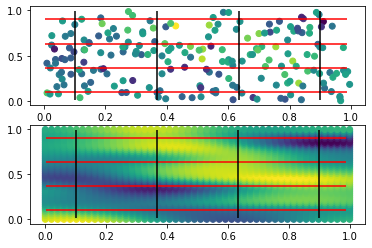

Iteration: 220 , Loss: 733.4500806092626


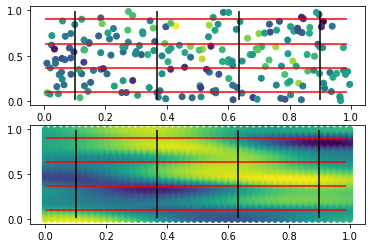

Iteration: 240 , Loss: 731.8463160753486


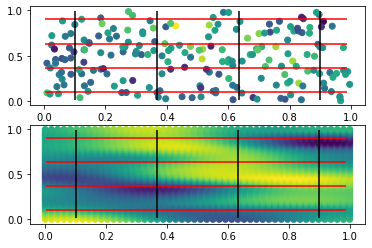

Iteration: 260 , Loss: 730.2536968920259


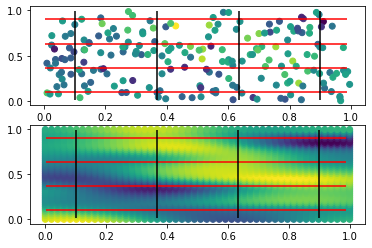

Iteration: 280 , Loss: 728.6720676467536


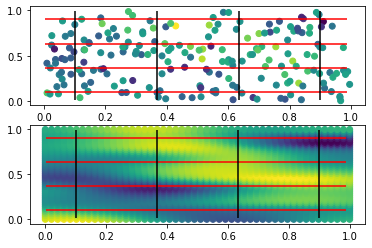

Iteration: 300 , Loss: 727.1012749180057


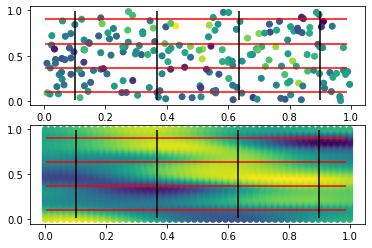

Iteration: 320 , Loss: 725.5411675193752


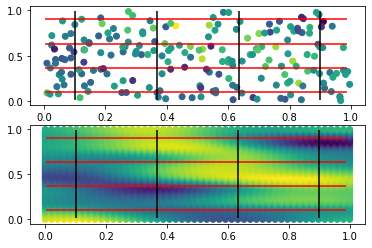

Iteration: 340 , Loss: 723.991596648543


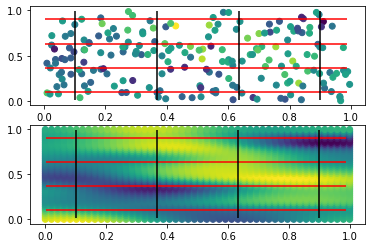

Iteration: 360 , Loss: 722.4524159742391


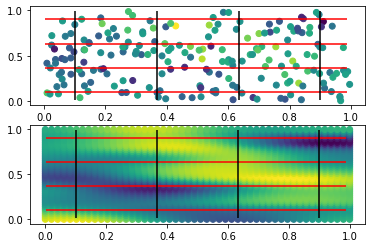

Iteration: 380 , Loss: 720.923481681832


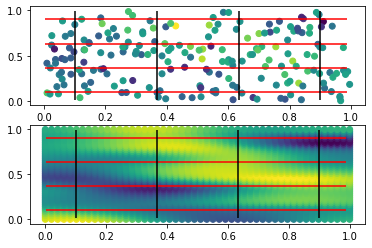

Iteration: 400 , Loss: 719.4046524907966


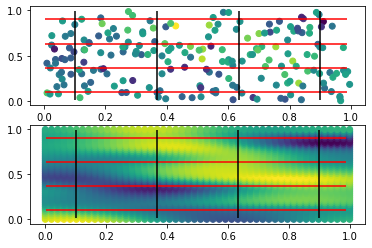

Iteration: 420 , Loss: 717.8957896527689


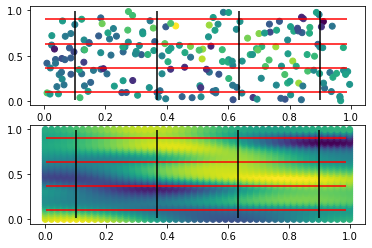

Iteration: 440 , Loss: 716.396756936067


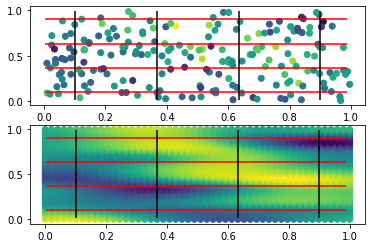

Iteration: 460 , Loss: 714.9074206007233


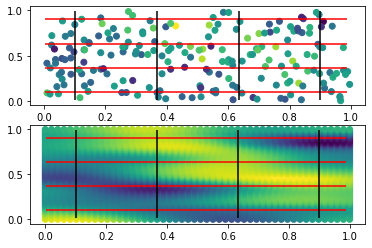

Iteration: 480 , Loss: 713.4276493668435


In [7]:
max_iter = ci_niter(500)

for i in range(max_iter):
    opt_step(data)
    if i % 20 == 0:
        plot_model(model)
        print("Iteration:", i, ", Loss:", model.loss(data).numpy())